In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


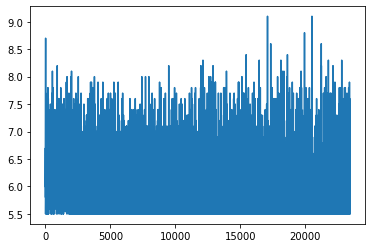

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
series = pd.read_csv('database.csv')
time = np.array(range(0,len(series['Date'])))
#time = pd.to_datetime(series['Date'],format = "%m/%d/%Y" )
Magnitude = np.array(np.array(series['Magnitude']))
#print(time)
plt.plot(time,Magnitude)
plt.show()

In [ ]:
split_time = 22000
time_train = time[:split_time]
x_train = Magnitude[:split_time]
time_valid = time[split_time:]
x_valid = Magnitude[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
print(len(series['Date']))

23412


In [ ]:
def windowed_dataset(Magnitude, window_size, batch_size, shuffle_buffer):
    Magnitude = tf.expand_dims(Magnitude, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(Magnitude)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, Magnitude, window_size):
    ds = tf.data.Dataset.from_tensor_slices(Magnitude)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(60).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([  
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),   
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(25, activation="relu"),  
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
220/220 [==============================] - 7s 20ms/step - loss: 0.5139 - mae: 0.8726
Epoch 2/50
220/220 [==============================] - 5s 21ms/step - loss: 0.3943 - mae: 0.7350
Epoch 3/50
220/220 [==============================] - 5s 20ms/step - loss: 0.3436 - mae: 0.6758
Epoch 4/50
220/220 [==============================] - 4s 20ms/step - loss: 0.3034 - mae: 0.6230
Epoch 5/50
220/220 [==============================] - 5s 20ms/step - loss: 0.2848 - mae: 0.5980
Epoch 6/50
220/220 [==============================] - 5s 20ms/step - loss: 0.2742 - mae: 0.5844
Epoch 7/50
220/220 [==============================] - 5s 21ms/step - loss: 0.2659 - mae: 0.5743
Epoch 8/50
220/220 [==============================] - 4s 20ms/step - loss: 0.2593 - mae: 0.5659
Epoch 9/50
220/220 [==============================] - 5s 20ms/step - loss: 0.2534 - mae: 0.5587
Epoch 10/50
220/220 [==============================] - 5s 20ms/step - loss: 0.2473 - mae: 0.5508
Epoch 11/50
220/220 [==================

In [ ]:
def plot_series(time, Magnitude , start=0, end=None):
    plt.plot(time[start:end], Magnitude[start:end], )
    plt.xlabel("Дата")
    plt.ylabel("Значение")
    plt.title("Валидация")
    plt.grid(True)

In [ ]:
rnn_forecast = model_forecast(model, Magnitude[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, -0]

In [ ]:
print(x_train)

[6.  5.8 6.2 ... 5.5 5.8 5.5]


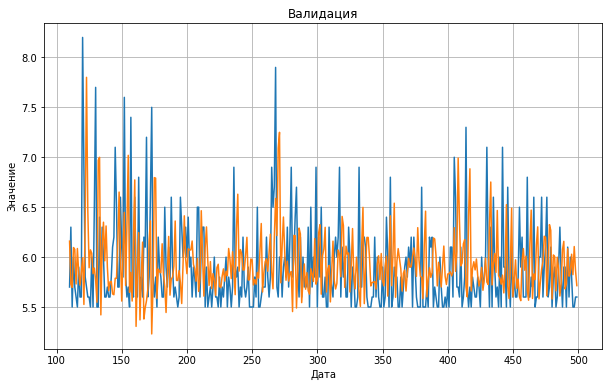

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_train[110:500], x_valid[110:500])
plot_series(time_train[110:500], rnn_forecast[110:500])

In [ ]:
print(rnn_forecast)

print(x_valid)

[5.813032  5.871468  5.632452  ... 5.896979  5.733336  5.6366525]
[5.7 6.2 5.7 ... 5.9 6.3 5.5]


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.39673588

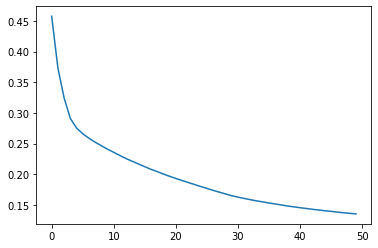

In [ ]:
plt.plot(history.epoch, history.history["loss"])
plt.show()

In [ ]:
print(history.history)

{'loss': [0.4575382173061371, 0.373386412858963, 0.3245077133178711, 0.2910018265247345, 0.2754100263118744, 0.2660054564476013, 0.2587117850780487, 0.2522142827510834, 0.24648907780647278, 0.24079084396362305, 0.23565663397312164, 0.23042750358581543, 0.22539515793323517, 0.22099505364894867, 0.21661852300167084, 0.21223261952400208, 0.20796316862106323, 0.20434506237506866, 0.200216144323349, 0.19659137725830078, 0.1930578202009201, 0.1897924244403839, 0.18643516302108765, 0.1832842081785202, 0.17995025217533112, 0.176876500248909, 0.17368243634700775, 0.17074066400527954, 0.16784802079200745, 0.16496078670024872, 0.16265353560447693, 0.16053327918052673, 0.15849465131759644, 0.15656231343746185, 0.15494117140769958, 0.1530773639678955, 0.151510089635849, 0.1498914211988449, 0.14819499850273132, 0.1468299776315689, 0.1454373151063919, 0.14413437247276306, 0.14284418523311615, 0.14164647459983826, 0.14044275879859924, 0.13944141566753387, 0.13822442293167114, 0.13720859587192535, 0.13

<Figure size 432x288 with 0 Axes>

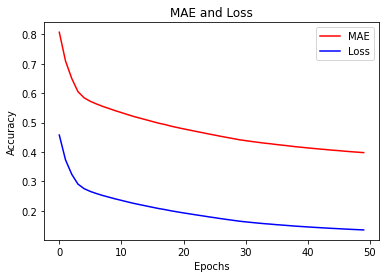

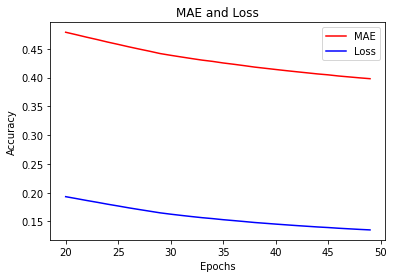

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 50)          3050      
_________________________________________________________________
dense_1 (Dense)              (None, None, 25)          1275      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           26        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

AttributeError: ignored